In [138]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [40]:
!pip install folium

In [3]:
!pip install BeautifulSoup4

In [4]:
!pip install geopy

  Stored in directory: C:\Users\Vidarsh\AppData\Local\pip\Cache\wheels\99\45\d1\14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [24]:
from bs4 import BeautifulSoup
from requests import get
from geopy.geocoders import Nominatim 

Getting HTML page from Wikipedia

In [25]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = get(url).text
soup = BeautifulSoup(page,'lxml')

Fetching Table with class name of wikitable sortable from read page

In [26]:
My_table=soup.find('table',{'class':'wikitable sortable'})
My_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></tr>
<tr>
<td>M6A</td>

parsing table rows and add them to array

In [27]:
My_table.find_all('tr')[1].find_all('td')
toronto=[]

for row in My_table.find_all('tr'):
    cols = row.find_all('td')
    if len(cols) == 3:
        toronto.append((cols[0].text.strip(), cols[1].text.strip(), cols[2].text.strip()))

Convert it to numpy array

In [28]:
toronto_array=np.asarray(toronto)
len(toronto_array)

288

Convert it to pandas dataframe and add columns

In [29]:
df = pd.DataFrame(toronto_array)
df.columns=['Postcode','Borough','Neighborhood']
df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


remove Not assigened rows from Borough columns

In [30]:
df=df[df['Borough']!='Not assigned']
df=df.reset_index(drop=True)
df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


Set not assigned neighbourhoods to respective Borough enrty

In [31]:
for i in range(len(df)):
    if df.iloc[i,2]=='Not assigned':
        df.iloc[i,2]=df.iloc[i,1]
        
df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


merge neighbouhoods based on Postcode and borough

In [32]:
df=df.groupby(['Postcode','Borough'],as_index=False).agg(", ".join)
df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [33]:
df.shape

(103, 3)

getting coordinates from geocoder

In [16]:
! pip install geocoder

In [34]:
latlang=pd.read_csv(r"C:\Users\Vidarsh\Desktop\Coursera_Capstone-master\Geospatial_Coordinates.csv")

In [35]:
latlang.columns=['Postcode','Latitude','Longitude']
latlang.head(10)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [36]:
df_latlang=pd.merge(df,latlang,on="Postcode")
df_latlang.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [37]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [44]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_latlang['Latitude'], df_latlang['Longitude'], df_latlang['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [58]:
for i in range(len(df_latlang)):
    if "Toronto" in df_latlang.iloc[i,1]:
        print(i)
        print(df_latlang.iloc[i,1])

37
East Toronto
41
East Toronto
42
East Toronto
43
East Toronto
44
Central Toronto
45
Central Toronto
46
Central Toronto
47
Central Toronto
48
Central Toronto
49
Central Toronto
50
Downtown Toronto
51
Downtown Toronto
52
Downtown Toronto
53
Downtown Toronto
54
Downtown Toronto
55
Downtown Toronto
56
Downtown Toronto
57
Downtown Toronto
58
Downtown Toronto
59
Downtown Toronto
60
Downtown Toronto
61
Downtown Toronto
63
Central Toronto
64
Central Toronto
65
Central Toronto
66
Downtown Toronto
67
Downtown Toronto
68
Downtown Toronto
69
Downtown Toronto
70
Downtown Toronto
75
Downtown Toronto
76
West Toronto
77
West Toronto
78
West Toronto
82
West Toronto
83
West Toronto
84
West Toronto
87
East Toronto


In [67]:
df_tor=df_latlang[df_latlang["Borough"].str.contains("Toronto")].reset_index(drop=True)
df_tor.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [68]:
map_Toronto_only = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_tor['Latitude'], df_tor['Longitude'], df_tor['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto_only)  
    
map_Toronto_only

In [69]:
CLIENT_ID = 'APBVPCWKYZ0Q2D5NYMBINMI4IETDGAYKNGBR0TO21WKVFCH1' # your Foursquare ID
CLIENT_SECRET = '2PXD4DBPYLM4AWBBYVRLHAZJFUF3QX5KPWOGBMGX4YW14VOQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: APBVPCWKYZ0Q2D5NYMBINMI4IETDGAYKNGBR0TO21WKVFCH1
CLIENT_SECRET:2PXD4DBPYLM4AWBBYVRLHAZJFUF3QX5KPWOGBMGX4YW14VOQ


In [71]:

neighborhood_latitude = df_tor.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_tor.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_tor.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [72]:
radius=500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=APBVPCWKYZ0Q2D5NYMBINMI4IETDGAYKNGBR0TO21WKVFCH1&client_secret=2PXD4DBPYLM4AWBBYVRLHAZJFUF3QX5KPWOGBMGX4YW14VOQ&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [74]:
results = get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cbf5fd7f594df21bb11f8a5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad4c062f964a52011f820e3',
       'name': 'The Big Carrot Natural Food Market',
       'location': {'address': '125 Southwood Dr',
        'lat': 43.678879,
        'lng': -79.297734,
        'labeledLatLngs': [{'label': 'display',
          'lat

In [75]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [78]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
1,Grover Pub and Grub,Pub,43.679181,-79.297215
2,Starbucks,Coffee Shop,43.678798,-79.298045
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [79]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [82]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [83]:
toronto_venues = getNearbyVenues(names=df_tor['Neighborhood'],
                                   latitudes=df_tor['Latitude'],
                                   longitudes=df_tor['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [91]:
print(toronto_venues.shape)
toronto_venues.head()

(1708, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [92]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,85,85,85,85,85,85
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [110]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


In [122]:
# one hot encoding
tor_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood_names'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]
tor_onehot.head()

,Neighborhood_names,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
tor_onehot.shape

(1708, 234)

In [124]:
tor_grouped = tor_onehot.groupby('Neighborhood_names').mean().reset_index()
tor_grouped

,Neighborhood_names,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,...,0.00,0.000000,0.000000,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.071429,0.071429,0.142857,0.214286,0.142857,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.000000,...,0.00,0.000000,0.000000,0.00,0.011765,0.000000,0.000000,0.011765,0.000000,0.011765
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.010000,0.000000,0.00,0.060000,0.000000,0.040000,0.010000,0.000000,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.010989,0.010989,0.000000,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,...,0.00,0.000000,0.000000,0.00,0.000000,0.010989,0.010989,0.000000,0.010989,0.021978


In [126]:
tor_grouped.shape

(38, 234)

In [127]:
num_top_venues = 5

for hood in tor_grouped['Neighborhood_names']:
    print("----"+hood+"----")
    temp = tor_grouped[tor_grouped['Neighborhood_names'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3  American Restaurant  0.04
4      Thai Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.04
3  Seafood Restaurant  0.04
4      Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
                  venue  freq
0        Breakfast Spot  0.09
1           Coffee Shop  0.09
2                  Café  0.09
3     Convenience Store  0.05
4  Caribbean Restaurant  0.05


----Business Reply Mail Processing Centre 969 Eastern----
              venue  freq
0       Pizza Place  0.06
1  Recording Studio  0.06
2        Smoke Shop  0.06
3     Burrito Place  0.06
4               Spa  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airpo

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [130]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_names']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood_names'] = tor_grouped['Neighborhood_names']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood_names,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Bakery,Restaurant,Gym,Hotel,Bar
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Café,Cheese Shop,Seafood Restaurant,Bakery,Farmers Market,Bistro
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym / Fitness Center,Italian Restaurant,Performing Arts Venue,Pet Store,Gym,Nightclub,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Gym / Fitness Center,Auto Workshop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop,Farmers Market
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Plane,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Airport Food Court,Airport


In [148]:
Sum_of_squared_distances = []
K = range(1,39)
for k in K:
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(tor_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

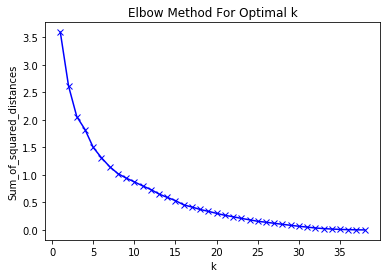

In [149]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [170]:
kclusters = 9

tor_grouped_clustering = tor_grouped.drop('Neighborhood_names', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 5, 6, 6, 6, 6,
       3, 6, 2, 6, 6, 4, 0, 6, 6, 6, 6, 6, 6, 1, 6, 6])

In [171]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


ValueError: cannot insert Cluster Labels, already exists

In [172]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood_names,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Bakery,Restaurant,Gym,Hotel,Bar
1,6,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Restaurant,Café,Cheese Shop,Seafood Restaurant,Bakery,Farmers Market,Bistro
2,6,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Gym / Fitness Center,Italian Restaurant,Performing Arts Venue,Pet Store,Gym,Nightclub,Climbing Gym
3,6,Business Reply Mail Processing Centre 969 Eastern,Gym / Fitness Center,Auto Workshop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop,Farmers Market
4,7,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Plane,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Airport Food Court,Airport
5,6,"Cabbagetown, St. James Town",Coffee Shop,Park,Restaurant,Café,Pizza Place,Italian Restaurant,Pub,Bakery,Diner,Chinese Restaurant
6,6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Ice Cream Shop,Bar,Bubble Tea Shop,Burger Joint,Sandwich Place,Salad Place,Spa
7,6,"Chinatown, Grange Park, Kensington Market",Café,Bar,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Mexican Restaurant,Bakery,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,Grocery Store
8,6,Christie,Grocery Store,Café,Park,Restaurant,Baby Store,Italian Restaurant,Nightclub,Diner,Coffee Shop,Convenience Store
9,6,Church and Wellesley,Japanese Restaurant,Coffee Shop,Gay Bar,Sushi Restaurant,Gym,Restaurant,Yoga Studio,Dance Studio,Pub,Nightclub


In [173]:
tor_merged = df_tor
tor_merged.columns=["Postcode","Borough","Neighborhood_names","Latitude","Longitude"]
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood_names'), on='Neighborhood_names')

tor_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood_names,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Coffee Shop,Pub,Neighborhood,Convenience Store,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,6,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Bubble Tea Shop,Sports Bar,Spa,Japanese Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,6,Sandwich Place,Pet Store,Movie Theater,Steakhouse,Food & Drink Shop,Intersection,Sushi Restaurant,Brewery,Pub,Ice Cream Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,6,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Camera Store,Spa,Fish Market,Bookstore,Latin American Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [174]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood_names'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [175]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,0,Garden,Music Venue,Home Service,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 2

In [176]:
tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,1,Health Food Store,Coffee Shop,Pub,Neighborhood,Convenience Store,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 3

In [183]:
tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,2,Playground,Yoga Studio,Dim Sum Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### Cluster 4

In [182]:
tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,3,Park,Swim School,Bus Line,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 5

In [181]:
tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,4,Park,Playground,Trail,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Cluster 6

In [180]:
tor_merged.loc[tor_merged['Cluster Labels'] == 5, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,5,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 7

In [179]:
tor_merged.loc[tor_merged['Cluster Labels'] == 6, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,6,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Furniture / Home Store,Bubble Tea Shop,Sports Bar,Spa,Japanese Restaurant
2,East Toronto,6,Sandwich Place,Pet Store,Movie Theater,Steakhouse,Food & Drink Shop,Intersection,Sushi Restaurant,Brewery,Pub,Ice Cream Shop
3,East Toronto,6,Café,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Camera Store,Spa,Fish Market,Bookstore,Latin American Restaurant
6,Central Toronto,6,Sporting Goods Shop,Coffee Shop,Yoga Studio,Fast Food Restaurant,Mexican Restaurant,Diner,Dessert Shop,Park,Clothing Store,Chinese Restaurant
7,Central Toronto,6,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Restaurant,Café,Thai Restaurant,Sushi Restaurant,Italian Restaurant,Diner
9,Central Toronto,6,Coffee Shop,Pub,American Restaurant,Light Rail Station,Sports Bar,Bagel Shop,Supermarket,Sushi Restaurant,Fried Chicken Joint,Vietnamese Restaurant
11,Downtown Toronto,6,Coffee Shop,Park,Restaurant,Café,Pizza Place,Italian Restaurant,Pub,Bakery,Diner,Chinese Restaurant
12,Downtown Toronto,6,Japanese Restaurant,Coffee Shop,Gay Bar,Sushi Restaurant,Gym,Restaurant,Yoga Studio,Dance Studio,Pub,Nightclub
13,Downtown Toronto,6,Coffee Shop,Pub,Bakery,Park,Café,Mexican Restaurant,Restaurant,Breakfast Spot,Theater,Gym / Fitness Center
14,Downtown Toronto,6,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Restaurant,Diner,Fast Food Restaurant,Bubble Tea Shop,Italian Restaurant


#### Cluster 8

In [178]:
tor_merged.loc[tor_merged['Cluster Labels'] == 7, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Downtown Toronto,7,Airport Service,Airport Terminal,Airport Lounge,Plane,Harbor / Marina,Sculpture Garden,Boutique,Boat or Ferry,Airport Food Court,Airport


#### Cluster 9

In [177]:
tor_merged.loc[tor_merged['Cluster Labels'] == 8, tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Toronto,8,Pizza Place,Breakfast Spot,Grocery Store,Hotel,Food & Drink Shop,Dance Studio,Park,Clothing Store,Sandwich Place,Burger Joint
